<a href="https://colab.research.google.com/github/ju-ki/atma10/blob/master/exp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText xfeat category_encoders texthero geopy umap transformers
!rm -rf fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 30.63 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 1.9MB 12.0MB/s 
     |████████████████████████████████| 296kB 35.8MB/s 
     |████████████████████████████████| 1.4MB 50.9MB/s 
     |████████████████████████████████| 245kB 52.5MB/s 
     |████████████████████████████████| 890kB 49.3MB/s 
     |████████████████████████████████| 3.2MB 66.6MB/s 
     |████████████████████████████████| 163kB 68.4MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 143kB 56.9MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |██████████████████████████████

In [4]:
import os 
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import texthero as hero
from fasttext import load_model
from tqdm import tqdm

import torch
import transformers
from transformers import BertTokenizer, RobertaTokenizer, RobertaForSequenceClassification

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import umap.umap_ as umap

sns.set()
CODE_PATH = "/content/drive/MyDrive/atmacup10/code/"
INPUT_PATH = "/content/drive/MyDrive/atmacup10/data/raw/"
OUTPUT_PAHT = "/content/drive/MyDrive/atmacup10/data/submission/"

os.chdir(CODE_PATH)
from feature_engine import *
from nlp_feature import *
from util import AbstractBaseBlock, WrapperBlock

In [8]:
import inspect

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper

@cachable
def read_csv(name):

    if '.csv' not in name:
        name = name + '.csv'

    return pd.read_csv(os.path.join(INPUT_PATH, name))

In [11]:
train_df = read_csv("train")
test_df = read_csv("test")
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [18]:
GetCountString("description").fit(train_df)[GetCountString("description").fit(train_df)["count_string_description"] < 4]

,count_string_description
0,3
1,3
9,3
16,3
17,3
...,...
12003,3
12011,3
12012,3
12013,3


In [35]:
class GetCountWord(AbstractBaseBlock):
  def __init__(self, cols):
    self.cols = cols
  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df[self.cols] = input_df[self.cols].fillna("NaN")
    out_df[self.cols] = out_df[self.cols].apply(lambda x: len(x.split()))
    return out_df.add_prefix("count_word_")

In [41]:
GetCountWord("description").fit(train_df)[GetCountWord("description").fit(train_df)["count_word_description"] < 3]

,count_word_description
0,1
1,1
9,1
16,1
17,1
...,...
12003,1
12011,1
12012,1
12013,1


In [52]:
class GetLanguageLabel(AbstractBaseBlock):
  """
  言語判定するブロック
  """
  def __init__(self, cols):
    self.cols = cols

  def fit(self, input_df):
    return self.transform(input_df)

  def transform(self, input_df):
    out_df = pd.DataFrame()
    self.model = load_model("/content/drive/MyDrive/atmacup10/data/external/lid.176.bin")
    out_df[self.cols] = input_df[self.cols].fillna("").map(lambda x: self.model.predict(x.replace("\n", ""))[0][0])
    return out_df.add_prefix("lang_label_")

In [59]:
GetLanguageLabel("title").fit(train_df)["lang_label_title"].value_counts()

__label__nl     9090
__label__en     2342
__label__de      213
__label__fr      147
__label__es       65
__label__it       53
__label__id       19
__label__af       18
__label__fi       11
__label__pl       11
__label__sv        6
__label__la        5
__label__ca        4
__label__ms        4
__label__tr        3
__label__da        3
__label__ceb       3
__label__ru        3
__label__fy        3
__label__eo        2
__label__sk        2
__label__sl        2
__label__hu        2
__label__pt        2
__label__ia        2
__label__no        2
__label__sq        2
__label__br        1
__label__hr        1
__label__et        1
__label__az        1
__label__li        1
__label__eu        1
__label__fa        1
Name: lang_label_title, dtype: int64

In [60]:
GetLanguageLabel("title").transform(test_df)["lang_label_title"].value_counts()

__label__nl     9045
__label__en     2328
__label__de      192
__label__fr      172
__label__es       82
__label__it       59
__label__af       16
__label__sv       13
__label__id       13
__label__pl        9
__label__ca        9
__label__fi        8
__label__no        7
__label__pt        6
__label__et        6
__label__eo        6
__label__da        5
__label__tr        4
__label__br        3
__label__la        2
__label__ms        2
__label__ro        2
__label__cs        2
__label__sr        2
__label__gl        2
__label__vi        2
__label__fy        2
__label__hr        1
__label__sh        1
__label__mk        1
__label__ru        1
__label__hy        1
__label__ceb       1
__label__eu        1
__label__nds       1
__label__fa        1
Name: lang_label_title, dtype: int64

In [63]:
class AggregationBlock(AbstractBaseBlock):
    """
    集約変数を作成するブロック
    
    cols:
      group_key:元になる変数:age, country etc..
      group_values:集約を行う対象の変数:n_items etc..
      agg_methods:どのような方法で集約するか. デフォルトはmax, min, meanの三つ
    """
    def __init__(self, group_key, group_values, agg_methods=["max", "min", "mean"]):
        self.group_key = group_key
        self.group_values = group_values
        self.agg_methods = agg_methods
     
    def transform(self, input_df):
        self.agg_df, self.agg_col = xfeat.aggregation(input_df,
                                        agg_methods=self.agg_methods,
                                        group_key=self.group_key,
                                        group_values=self.group_values)
        
        out_df = pd.DataFrame()
        out_df = self.agg_df
        return out_df[self.agg_col]

In [65]:
AggregationBlock(group_key="principal_maker",
                  group_values=["dating_period"]).transform(test_df)

,agg_max_dating_period_grpby_principal_maker,agg_min_dating_period_grpby_principal_maker,agg_mean_dating_period_grpby_principal_maker
0,19,19,19.000000
1,17,17,17.000000
2,18,18,18.000000
3,19,19,19.000000
4,18,17,17.814815
...,...,...,...
12003,19,19,19.000000
12004,19,19,19.000000
12005,19,19,19.000000
12006,19,19,19.000000


In [66]:
def unit_mm_for_sub_title(input_df):
  out_df = pd.DataFrame()
  for axis in ['h', 'w', 't', 'd']:
    column_name = f'size_{axis}'
    size_info = input_df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis))
    size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
    size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) 
    size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) 
    input_df[column_name] = size_info[column_name] 
    out_df[column_name] = input_df[column_name]
  return out_df

In [69]:
WrapperBlock(unit_mm_for_sub_title).transform(test_df)

,size_h,size_w,size_t,size_d
0,167.0,108.0,NaN,NaN
1,297.0,241.0,NaN,NaN
2,270.0,215.0,NaN,NaN
3,116.0,159.0,NaN,NaN
4,108.0,184.0,NaN,NaN
...,...,...,...,...
12003,32.0,51.0,NaN,NaN
12004,271.0,337.0,NaN,NaN
12005,NaN,NaN,NaN,NaN
12006,30.0,50.0,NaN,NaN


In [71]:
material = read_csv("material")
material

,object_id,name
0,000405d9a5e3f49fc49d,photographic paper
1,000405d9a5e3f49fc49d,cardboard
2,001020bd00b149970f78,oil paint (paint)
3,001020bd00b149970f78,panel
4,0011d6be41612ec9eae3,oil paint (paint)
...,...,...
35389,fffbe07b997bec00e203,photographic paper
35390,fffbe07b997bec00e203,cardboard
35391,fffd43b134ba7197d890,photographic paper
35392,ffff22ea12d7f99cff31,paper


In [78]:
vc = material["name"].value_counts()
use_material = vc[vc > 19].index
idx = material["name"].isin(use_material)
new_material = material[idx].reset_index(drop=True)
pd.crosstab(new_material["object_id"], new_material["name"])

name,RC paper,baryta paper,canvas,cardboard,celluloid (cellulosic),copper (metal),glass,ink,leather,linen (material),metal,oil paint (paint),panel,paper,pencil,photographic paper,tempera,velvet (fabric weave),wood (plant material)
object_id,,,,,,,,,,,,,,,,,,,
000405d9a5e3f49fc49d,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
001020bd00b149970f78,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
0011d6be41612ec9eae3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
0012765f7a97ccc3e9e9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
00133be3ff222c9b74b0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff1d87d79953ddab2c6,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
fff4bbb55fd7702d294e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
fffbe07b997bec00e203,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [79]:
OBJECT_ID = "object_id"
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

In [84]:
class MaterialBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      material_df = read_csv('material')
      vc = material_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = material_df['name'].isin(use_names)
      _use_df = material_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'MaterialBlock_name=')

In [92]:
MaterialBlock(min_count=19).fit(train_df)

,MaterialBlock_name=RC paper,MaterialBlock_name=baryta paper,MaterialBlock_name=canvas,MaterialBlock_name=cardboard,MaterialBlock_name=celluloid (cellulosic),MaterialBlock_name=copper (metal),MaterialBlock_name=glass,MaterialBlock_name=ink,MaterialBlock_name=leather,MaterialBlock_name=linen (material),MaterialBlock_name=metal,MaterialBlock_name=oil paint (paint),MaterialBlock_name=panel,MaterialBlock_name=paper,MaterialBlock_name=pencil,MaterialBlock_name=photographic paper,MaterialBlock_name=tempera,MaterialBlock_name=velvet (fabric weave),MaterialBlock_name=watercolor (paint),MaterialBlock_name=wood (plant material)
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
technique_df = read_csv("technique")
technique_df["name"].value_counts()

etching                          5936
engraving                        5563
albumen print                    5544
gelatin silver print             1158
letterpress printing              722
drypoint                          229
salted paper print                221
slide                             203
painting                          184
steel engraving                   161
collotype                         103
ambrotype                          74
inkjet print                       68
colour woodcut                     53
brush                              48
cyanotype                          43
pen                                34
gelatin silver slide on glass      26
carbon print                       25
ferrotyping                        24
photolithography                   12
gilding                            11
counterproof                       10
writing (processes)                 9
lacquering                          8
printing                            4
oil transfer

In [89]:
class TechiqueBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      techique_df = read_csv('technique')
      vc = technique_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = technique_df['name'].isin(use_names)
      _use_df = technique_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'TechniqueBlock_name=')

In [94]:
TechiqueBlock(min_count=20).fit(train_df)

,TechniqueBlock_name=albumen print,TechniqueBlock_name=ambrotype,TechniqueBlock_name=brush,TechniqueBlock_name=carbon print,TechniqueBlock_name=collotype,TechniqueBlock_name=colour woodcut,TechniqueBlock_name=cyanotype,TechniqueBlock_name=drypoint,TechniqueBlock_name=engraving,TechniqueBlock_name=etching,TechniqueBlock_name=ferrotyping,TechniqueBlock_name=gelatin silver print,TechniqueBlock_name=gelatin silver slide on glass,TechniqueBlock_name=inkjet print,TechniqueBlock_name=letterpress printing,TechniqueBlock_name=painting,TechniqueBlock_name=pen,TechniqueBlock_name=salted paper print,TechniqueBlock_name=slide,TechniqueBlock_name=steel engraving
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [95]:
class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [112]:
def create_reduction_bert_feature(input_df, cols, methods, N):
  BSV = BertSequenceVectorizer()
  _input_df = input_df.copy()
  _input_df[cols] = _input_df[cols].fillna("NaN")
  _input_df[cols + "_feature"] = _input_df[cols].progress_apply(lambda x: BSV.vectorize(x))

  x = pd.DataFrame(
      np.stack(_input_df[cols + "_feature"])
  )
  method = methods(n_components=N)
  transformed = method.fit_transform(x)
  out_df = pd.DataFrame(
      transformed,
      columns = [f"{methods}_{n}_feature" for n in range(N)]
  )
  return out_df

def get_period_of_production(input_df):
  out_df = pd.DataFrame()
  out_df["period_of_production"] = input_df["dating_year_late"] - input_df["dating_year_early"]
  return out_df.fillna(0)

def get_time_between_late_year_and_acqusition(input_df):
  input_df["acquisition_date"] = pd.to_datetime(input_df["acquisition_date"])
  input_df["year"] = input_df["acquisition_date"].dt.year.fillna(0)
  out_df = pd.DataFrame()
  out_df["period_of_acquisition_date"] = input_df["year"]- input_df["dating_year_late"].fillna(0).astype(float)
  return out_df.fillna(0)

In [98]:
from time import time
from tqdm import tqdm
from contextlib import contextmanager

def get_function(block,is_train):
    s = mapping ={
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block,s)

def to_feature(input_df,remain_df,blocks,is_train=False):
    out_df = remain_df
    
    for block in tqdm(blocks,total=len(blocks)):
        func = get_function(block,is_train)
        
        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)
        print(len(_df), len(input_df))
        assert len(_df) == len(input_df),func._name_
        out_df = pd.concat([out_df,_df],axis=1)
    return out_df

@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
  if prefix: format_str = str(prefix) + format_str
  if suffix: format_str = format_str + str(suffix)
  start = time()
  yield
  d = time() - start
  out_str = format_str.format(d)
  if logger:
    logger.info(out_str)
  else:
    print(out_str)

In [99]:
add_feature_block = [
                     WrapperBlock(unit_mm_for_sub_title),
                     WrapperBlock(get_period_of_production),
                     WrapperBlock(get_time_between_late_year_and_acqusition),
                     GetLanguageLabel("title"),
                     GetLanguageLabel("description"),
                     GetCountString("title"),
                     GetCountWord("title"),
                     GetCountString("description"),
                     GetCountWord("description"),
                     GetCountString("acquisition_credit_line"),
                     GetCountWord("acquisition_credit_line"),
                     GetCountString("long_title"),
                     GetCountWord("long_title"),
                     GetCountString("more_title"),
                     GetCountWord("more_title"),
                     GetCountString("sub_title"),

]

train_feat_df = to_feature(train, train, add_feature_block, is_train=True)
test_feat_df = to_feature(test, test, add_feature_block, is_train=False)

  6%|▋         | 1/16 [00:00<00:07,  1.95it/s]

create<util.WrapperBlock object at 0x7fc240ab51d0> 0.509[s]
12026 12026
create<util.WrapperBlock object at 0x7fc240ab58d0> 0.003[s]
12026 12026
create<util.WrapperBlock object at 0x7fc240ab5190> 0.011[s]
12026 12026


 25%|██▌       | 4/16 [00:00<00:04,  2.46it/s]

create<__main__.GetLanguageLabel object at 0x7fc240ab5990> 0.431[s]
12026 12026


 62%|██████▎   | 10/16 [00:01<00:02,  2.95it/s]

create<__main__.GetLanguageLabel object at 0x7fc240ab5a90> 0.625[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fc240ab5b90> 0.011[s]
12026 12026
create<__main__.GetCountWord object at 0x7fc240ab5450> 0.012[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fc240ab5210> 0.008[s]
12026 12026
create<__main__.GetCountWord object at 0x7fc240ab5710> 0.025[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fc240ab5d90> 0.007[s]
12026 12026
create<__main__.GetCountWord object at 0x7fc240ab5050> 0.012[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fc240ab52d0> 0.007[s]
12026 12026
create<__main__.GetCountWord object at 0x7fc240ab5750> 0.014[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fc240ab5690> 0.007[s]
12026 12026


  0%|          | 0/16 [00:00<?, ?it/s]

create<__main__.GetCountWord object at 0x7fc240ab5b10> 0.015[s]
12026 12026
create<nlp_feature.GetCountString object at 0x7fc240ab5c10> 0.008[s]
12026 12026


  6%|▋         | 1/16 [00:00<00:10,  1.38it/s]

create<util.WrapperBlock object at 0x7fc240ab51d0> 0.720[s]
12008 12008
create<util.WrapperBlock object at 0x7fc240ab58d0> 0.006[s]
12008 12008
create<util.WrapperBlock object at 0x7fc240ab5190> 0.008[s]
12008 12008


 25%|██▌       | 4/16 [00:01<00:06,  1.80it/s]

create<__main__.GetLanguageLabel object at 0x7fc240ab5990> 0.452[s]
12008 12008


 62%|██████▎   | 10/16 [00:01<00:02,  2.49it/s]

create<__main__.GetLanguageLabel object at 0x7fc240ab5a90> 0.574[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fc240ab5b90> 0.012[s]
12008 12008
create<__main__.GetCountWord object at 0x7fc240ab5450> 0.014[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fc240ab5210> 0.008[s]
12008 12008
create<__main__.GetCountWord object at 0x7fc240ab5710> 0.025[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fc240ab5d90> 0.008[s]
12008 12008
create<__main__.GetCountWord object at 0x7fc240ab5050> 0.009[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fc240ab52d0> 0.007[s]
12008 12008
create<__main__.GetCountWord object at 0x7fc240ab5750> 0.014[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fc240ab5690> 0.007[s]
12008 12008


100%|██████████| 16/16 [00:02<00:00,  7.93it/s]

create<__main__.GetCountWord object at 0x7fc240ab5b10> 0.014[s]
12008 12008
create<nlp_feature.GetCountString object at 0x7fc240ab5c10> 0.008[s]
12008 12008


In [100]:
train_feat_df.shape, test_feat_df.shape

((12026, 42), (12008, 41))

In [104]:
agg_columns = ["dating_period", "count_string_title", "count_string_description", "count_string_sub_title", "count_string_more_title", "count_string_long_title",
                 "count_string_acquisition_credit_line", "period_of_production", "period_of_acquisition_date"]
process_blocks = [
                 LabelEncodingBlock("acquisition_method"),
                 LabelEncodingBlock("principal_maker"),
                 LabelEncodingBlock("lang_label_title"),
                 LabelEncodingBlock("lang_label_description"),
                 LabelEncodingBlock("title"),
                 LabelEncodingBlock("description"),
                 CountEncodingBlock("acquisition_method"),
                 CountEncodingBlock("principal_maker"),
                 CountEncodingBlock("lang_label_title"),
                 CountEncodingBlock("lang_label_description"),
                 CountEncodingBlock("title"),
                 CountEncodingBlock("description"),
                 MaterialBlock(min_count=19),
                 TechiqueBlock(min_count=20),
                 AggregationBlock(group_key="acquisition_method",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="principal_maker",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="lang_label_title",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="lang_label_description",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="title",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="dating_period",
                                  group_values=["count_string_title", "count_string_description", "count_string_sub_title", "count_string_more_title", "count_string_long_title",
                                                 "count_string_acquisition_credit_line", "period_of_production", "period_of_acquisition_date"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                #  NameNGramBlock(whole_df, col="title", n=2),
                #  WrapperBlock(create_reduction_bert_feature(input_df=whole_df, cols="description", methods=PCA, N=3))
                 ]
drop_columns = ["description", "title", "principal_maker", "principal_or_first_maker", "long_title", "object_id", "art_series_id",
                  "sub_title", "copyright_holder", "more_title", "acquisition_credit_line", "dating_presenting_date",
                  "dating_sorting_date", "acquisition_date", "acquisition_method", "lang_label_title", "lang_label_description"]
train_feat_df = to_feature(train_feat_df,train_feat_df.drop(columns=drop_columns, axis=1),process_blocks, is_train=True)

test_feat_df = to_feature(test_feat_df,test_feat_df.drop(columns=drop_columns, axis=1),process_blocks,is_train=False)




  0%|          | 0/20 [00:00<?, ?it/s]


 35%|███▌      | 7/20 [00:00<00:00, 67.54it/s]

create<feature_engine.LabelEncodingBlock object at 0x7fc23deece50> 0.018[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fc23deecfd0> 0.009[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fc23deec850> 0.008[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fc23deec950> 0.008[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fc23deecad0> 0.015[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fc23deecb10> 0.012[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7fc23deecf50> 0.007[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7fc23deeca50> 0.015[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7fc23deec990> 0.007[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7fc23deecf90> 0.007[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7fc23deecb50> 0.011[s]
12026 12026
create<feature_engine.CountEncod




 65%|██████▌   | 13/20 [00:00<00:00, 38.16it/s]

create<__main__.MaterialBlock object at 0x7fc23deecc90> 0.237[s]
12026 12026
create<__main__.TechiqueBlock object at 0x7fc23deec1d0> 0.160[s]
12026 12026





 75%|███████▌  | 15/20 [00:01<00:00,  5.09it/s]

create<__main__.AggregationBlock object at 0x7fc23deeccd0> 1.007[s]
12026 12026





 75%|███████▌  | 15/20 [00:19<00:00,  5.09it/s]


 80%|████████  | 16/20 [00:24<00:27,  6.88s/it]

create<__main__.AggregationBlock object at 0x7fc23deec890> 22.466[s]
12026 12026





 85%|████████▌ | 17/20 [00:25<00:15,  5.22s/it]

create<__main__.AggregationBlock object at 0x7fc23deec610> 1.304[s]
12026 12026





 90%|█████████ | 18/20 [00:26<00:07,  3.98s/it]

create<__main__.AggregationBlock object at 0x7fc23deece10> 1.051[s]
12026 12026





 95%|█████████▌| 19/20 [02:05<00:32, 32.52s/it]

create<__main__.AggregationBlock object at 0x7fc23deec4d0> 99.071[s]
12026 12026





100%|██████████| 20/20 [02:06<00:00,  6.32s/it]



  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead




 45%|████▌     | 9/20 [00:00<00:00, 84.24it/s]

create<__main__.AggregationBlock object at 0x7fc23deeca90> 0.834[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7fc23deece50> 0.013[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fc23deecfd0> 0.008[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fc23deec850> 0.009[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fc23deec950> 0.008[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fc23deecad0> 0.011[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7fc23deecb10> 0.011[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7fc23deecf50> 0.006[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7fc23deeca50> 0.007[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7fc23deec990> 0.007[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7fc23deecf90> 0.013[s]
12008 12008
create<feature_engine.CountEncodingBlock




 75%|███████▌  | 15/20 [00:01<00:00, 15.89it/s]

create<__main__.AggregationBlock object at 0x7fc23deeccd0> 0.996[s]
12008 12008





 75%|███████▌  | 15/20 [00:13<00:00, 15.89it/s]


 80%|████████  | 16/20 [00:23<00:27,  6.79s/it]

create<__main__.AggregationBlock object at 0x7fc23deec890> 22.460[s]
12008 12008





 85%|████████▌ | 17/20 [00:24<00:15,  5.14s/it]

create<__main__.AggregationBlock object at 0x7fc23deec610> 1.262[s]
12008 12008





 90%|█████████ | 18/20 [00:26<00:07,  3.91s/it]

create<__main__.AggregationBlock object at 0x7fc23deece10> 1.029[s]
12008 12008





 95%|█████████▌| 19/20 [02:04<00:32, 32.32s/it]

create<__main__.AggregationBlock object at 0x7fc23deec4d0> 98.575[s]
12008 12008





100%|██████████| 20/20 [02:05<00:00,  6.28s/it]

create<__main__.AggregationBlock object at 0x7fc23deeca90> 0.829[s]
12008 12008


In [106]:
train_feat_df.shape, test_feat_df.shape

((12026, 395), (12008, 394))

In [108]:
test_feat_df.head()

,dating_period,dating_year_early,dating_year_late,size_h,size_w,size_t,size_d,size_h,size_w,size_t,size_d,period_of_production,period_of_acquisition_date,count_string_title,count_word_title,count_string_description,count_word_description,count_string_acquisition_credit_line,count_word_acquisition_credit_line,count_string_long_title,count_word_long_title,count_string_more_title,count_word_more_title,count_string_sub_title,LE_acquisition_method,LE_principal_maker,LE_lang_label_title,LE_lang_label_description,LE_title,LE_description,CE_acquisition_method,CE_principal_maker,CE_lang_label_title,CE_lang_label_description,CE_title,CE_description,MaterialBlock_name=RC paper,MaterialBlock_name=baryta paper,MaterialBlock_name=canvas,MaterialBlock_name=cardboard,...,agg_min_count_string_title_grpby_dating_period,agg_min_count_string_description_grpby_dating_period,agg_min_count_string_sub_title_grpby_dating_period,agg_min_count_string_more_title_grpby_dating_period,agg_min_count_string_long_title_grpby_dating_period,agg_min_count_string_acquisition_credit_line_grpby_dating_period,agg_min_period_of_production_grpby_dating_period,agg_min_period_of_acquisition_date_grpby_dating_period,agg_std_count_string_title_grpby_dating_period,agg_std_count_string_description_grpby_dating_period,agg_std_count_string_sub_title_grpby_dating_period,agg_std_count_string_more_title_grpby_dating_period,agg_std_count_string_long_title_grpby_dating_period,agg_std_count_string_acquisition_credit_line_grpby_dating_period,agg_std_period_of_production_grpby_dating_period,agg_std_period_of_acquisition_date_grpby_dating_period,agg_median_count_string_title_grpby_dating_period,agg_median_count_string_description_grpby_dating_period,agg_median_count_string_sub_title_grpby_dating_period,agg_median_count_string_more_title_grpby_dating_period,agg_median_count_string_long_title_grpby_dating_period,agg_median_count_string_acquisition_credit_line_grpby_dating_period,agg_median_period_of_production_grpby_dating_period,agg_median_period_of_acquisition_date_grpby_dating_period,agg_<function max_min at 0x7fc25ad227a0>_count_string_title_grpby_dating_period,agg_<function max_min at 0x7fc25ad227a0>_count_string_description_grpby_dating_period,agg_<function max_min at 0x7fc25ad227a0>_count_string_sub_title_grpby_dating_period,agg_<function max_min at 0x7fc25ad227a0>_count_string_more_title_grpby_dating_period,agg_<function max_min at 0x7fc25ad227a0>_count_string_long_title_grpby_dating_period,agg_<function max_min at 0x7fc25ad227a0>_count_string_acquisition_credit_line_grpby_dating_period,agg_<function max_min at 0x7fc25ad227a0>_period_of_production_grpby_dating_period,agg_<function max_min at 0x7fc25ad227a0>_period_of_acquisition_date_grpby_dating_period,agg_<function q75_q25 at 0x7fc247818a70>_count_string_title_grpby_dating_period,agg_<function q75_q25 at 0x7fc247818a70>_count_string_description_grpby_dating_period,agg_<function q75_q25 at 0x7fc247818a70>_count_string_sub_title_grpby_dating_period,agg_<function q75_q25 at 0x7fc247818a70>_count_string_more_title_grpby_dating_period,agg_<function q75_q25 at 0x7fc247818a70>_count_string_long_title_grpby_dating_period,agg_<function q75_q25 at 0x7fc247818a70>_count_string_acquisition_credit_line_grpby_dating_period,agg_<function q75_q25 at 0x7fc247818a70>_period_of_production_grpby_dating_period,agg_<function q75_q25 at 0x7fc247818a70>_period_of_acquisition_date_grpby_dating_period
0,19,1850.0,1900.0,167.0,108.0,NaN,NaN,167.0,108.0,NaN,NaN,50.0,94.0,51,8,3,1,3,1,84,13,51,8,17,5,107.0,2.0,1,-1.0,1.0,3904,6,9045,3689,1,3685,0.0,0.0,0.0,1.0,...,3,3,3,3,25,3,0.0,-1930.0,29.214139,95.993149,4.581922,43.190012,31.800587,24.406958,16.325031,410.459047,42.0,3.0,17,50,77.0,3,10.0,104.0,283,1641,48,594,299,161,85.0,3899.0,31.0,98.0,1.0,48.0,36.0,18,25.0,47.0
1,17,1609.0,1633.0,297.0,241.0,NaN,NaN,297.0,241.0,NaN,NaN,24.0,165.0,59,9,230,34,3,1,120,20,59,9,19,8,273.0,1.0,2,-1.0,-1.0,47,16,2328,8273,1,1,0.0,0.0,0.0,0.0,...,3,3,3,3,25,3,0.0,-1749.

In [114]:
drop_columns = ["size_h", "size_w", "size_t", "size_d"]
train_feat_df = train_feat_df.drop(columns=drop_columns, axis=1)
test_feat_df = test_feat_df.drop(columns=drop_columns, axis=1)
train_feat_df = train_feat_df.drop(columns=["likes"], axis=1)

In [115]:
y = np.log1p(train["likes"])

In [116]:

from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
def fit_lgbm(X,
             y,
             cv, 
             params: dict=None,
             verbose: int=50):
    
    metric_func = mean_squared_error
    
    if params is None:
        params = {}
        
    models = []
    
    oof_pred = np.zeros_like(y ,dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, x_valid = X[idx_train], X[idx_valid]
        y_train, y_valid = y[idx_train], y[idx_valid]
        
        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix="fit fold={}".format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=verbose,
                    verbose=verbose)
            
        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'K Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')
        
    score = metric_func(y, oof_pred) ** .5
    print('FINIHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [117]:
params = {
    "objective": "rmse",
    "max_depth": 7,
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "colsample_bytree": .5,
    "importance_type": "gain",
}

from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y))

oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.07317
[1000]	valid_0's rmse: 1.06209
[1500]	valid_0's rmse: 1.059
[2000]	valid_0's rmse: 1.05817
[2500]	valid_0's rmse: 1.0584
Early stopping, best iteration is:
[2122]	valid_0's rmse: 1.0579
fit fold=131.725[s]
K Fold 0 RMSLE: 1.0579
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.08324
[1000]	valid_0's rmse: 1.07021
[1500]	valid_0's rmse: 1.06258
[2000]	valid_0's rmse: 1.058
[2500]	valid_0's rmse: 1.05482
[3000]	valid_0's rmse: 1.05367
[3500]	valid_0's rmse: 1.05395
Early stopping, best iteration is:
[3166]	valid_0's rmse: 1.05342
fit fold=242.198[s]
K Fold 1 RMSLE: 1.0534
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.06397
[1000]	valid_0's rmse: 1.04928
[1500]	valid_0's rmse: 1.04381
[2000]	valid_0's rmse: 1.04119
[2500]	valid_0's rmse: 1.03952
[3000]	valid_0's rmse: 1.03895
[3500]	valid_0's rmse: 1.03866
Early stoppin

In [118]:

def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    return fig, ax

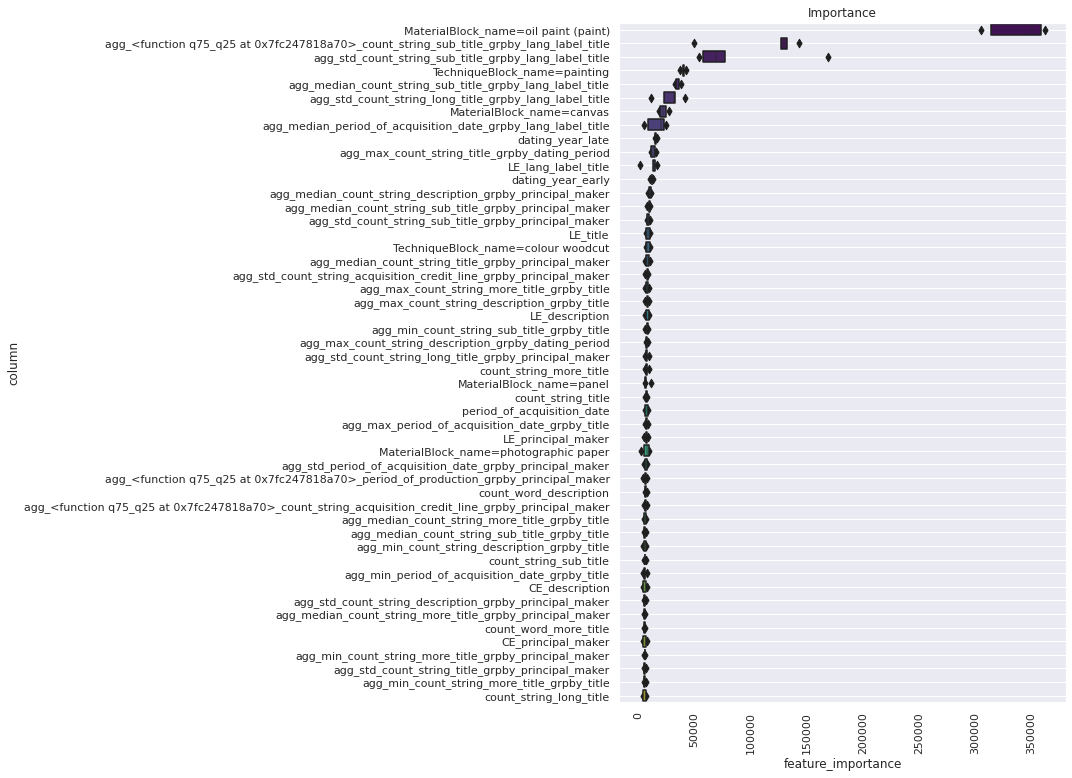

In [119]:
fig, _ = visualize_importance(models, feat_train_df=train_feat_df)

In [120]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred


pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
sub_df.to_csv(os.path.join(OUTPUT_PAHT, 'exp3.csv'), index=False)

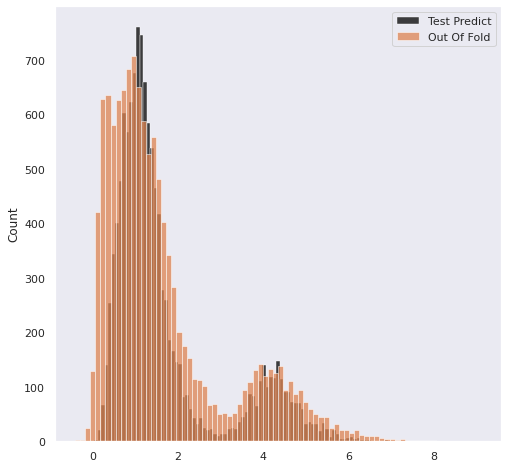

In [121]:

fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()